# Sparse Arrays Incorporated With Cluster Components


## Motive

The purpose of this notebook is to determine if implimenting Sparse Arrays will speed up the Connected Components portion of our pipeline.

## Pseudocode For Sparse Arrays Functions 

    ** Initialization:** (inputs: image)
        Give the Sparse Array a data member called "elements"
        Run Connected Components on the input image 
        Run clusterComponents on input image
        Threshold the clusterComponent by volume 
        For each index in this thresholded clusterComponent, add its value to elements 
        Give the Sparse Array a data member called "clusterList by using the genClusters function 

    **genClusters:** (input: image)
        create a variable called clusterList that will contain the Clusters
        for each unique label in the input image:
            find which indices in the Sparse Array are equal to that label 
            input these indices into the Cluster class and append this Cluster to clusterList
        return clusterList

    **addValue:** (inputs: tuple, value)
        if value is greater than 0:
            set self.elements at tuple equal to value 
        else if value equals 0 and there already exists a value at tuple: 
            set delete self.elemnts at tuple 

    **readValue:** (inputs: tuple)
        try:
            value gets self.elements at tuple 
        catch KeyError: 
            value = 0 (a.k.a. if there exists no element with that tuple, return 0)
        return value
        
## The Code

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../code/functions/')
import tiffIO as tIO
import connectLib as cLib
import plosLib as pLib
import time
import scipy.ndimage as ndimage
import numpy as np
import time

In [123]:
import clusterComponents

class SparseArray:
    def genClusters(self, image):
        clusterList = []
        for label in range(np.max(image)):
            memberList = []
            for z in range(len(image)):
                for y in range(len(image[z])):
                    for x in range(len(image[z][y])):
                        if (self.readValue((z, y, x)) == label):
                            memberList.append((z, y, x))
                            self.addValue((z, y, x), 0)
            clusterList.append(Cluster(memberList))
        return clusterList
    
    def __init__(self, input, threshold = 200):
        self.elements = {}
        imCC = clusterComponents.ClusterComponent(input)
        imCC.volumeThreshold(threshold)
        ccThresh = imCC.labeledIm
        for z in range(len(ccThresh)):
            for y in range(len(ccThresh[z])):
                for x in range(len(ccThresh[z][y])):
                    self.addValue((z, y, x), ccThresh[z][y][x])
        self.clusterList = self.genClusters(ccThresh)

    def addValue(self, tuple, value):
        if value > 0:
            self.elements[tuple] = value
        elif value == 0 and not(self.readValue(tuple) == 0):
            del self.elements[tuple]

    def readValue(self, tuple):
        try:
          value = self.elements[tuple]
        except KeyError:
          # could also be 0.0 if using floats...
          value = 0
        return value

## Cluster Class For Reference

In [77]:
import numpy as np
import math

class Cluster:
    def __init__(self, members):
        self.members = members
        self.volume = self.getVolume()

    def getVolume(self):
        return len(self.members)

    def getCentroid(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        return [np.average(listZ), np.average(listY), np.average(listX)]

    def getMembers(self):
        return self.members


## Trying on A Slice of 5

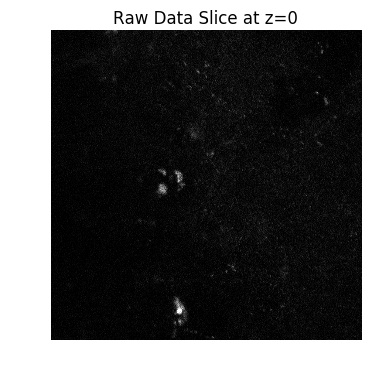

In [4]:
dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.axis('off')
plt.title('Raw Data Slice at z=0')
plt.show()

In [9]:
#finding the clusters after plosPipeline
plosOutSub = pLib.pipeline(dataSubset)

In [10]:
#binarize output of plos lib
bianOutSub = cLib.otsuVox(plosOutSub)

In [11]:
#dilate the output based on neigborhood size
bianOutSubDil = ndimage.morphology.binary_dilation(bianOutSub).astype(int)

In [132]:
sparse = SparseArray(bianOutSubDil)

In [108]:
intensities = []
index = 0
for z in range(len(bianOutSubThresh)):
    for y in range(len(bianOutSubThresh[z])):
        for x in range(len(bianOutSubThresh[z][y])):
            val = sparse.readValue((z, y, x))
            if  val > 0:
                intensities.append(val)
                index = index + 1

In [134]:
print 'Percentage of Volume\n\tActual: ' + str(1.0*np.max(index)/(1024*1024*3)) + '\tExpected: .015'
print 'Number of Clusters\n\tActual: ' + str(np.max(intensities)) + '\tExpected: 1500 - 2000'

Percentage of Volume
	Actual: 0.0157359441121	Expected: .015
Number of Clusters
	Actual: 1754	Expected: 1500 - 2000


In [114]:
displayIm = np.zeros_like(bianOutSubDil)
for z in range(len(bianOutSubDil)):
    for y in range(len(bianOutSubDil[z])):
        for x in range(len(bianOutSubDil[z][y])):
            displayIm[z][y][x] = sparse.readValue((z, y, x))

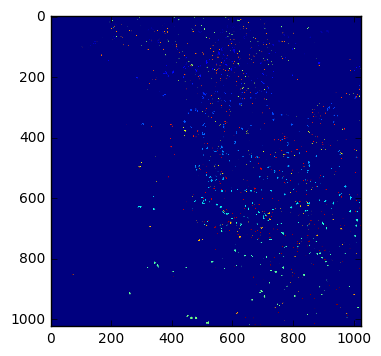

In [125]:
plt.imshow(displayIm[3])
plt.show()

**Results:**

After Storing the Data as a sparse array and counting the non-zero values, I found that the non-zero values (a.k.a. the detected Synapses) represented about 1.5% of the data. It also detected 1754 Synapses, which is also around how many were detected without using Sparse Arrays. Both of these signs indicate that the Sparse Array is storing values correctly.

The display image also looks as we would expect it to.

**Now, let's determine if it helps the Connected Components speed:**

In [136]:
start_time = time.time()
sparse = SparseArray(bianOutSubDil)
print time.time() - start_time

57874.5863619
